## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import tensorflow as tf
import itertools
# 不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 只使用 30% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 TensorFlow Session
tf.keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout


"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64, 32], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x) # 隨機在一次update中，忽略了20%的neurons間的connection
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x) # 隨機在一次update中，忽略了25%的neurons間的connection
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    #定義一個具有輸入和輸出的模型
    model = keras.models.Model(inputs=[input_layer], outputs=[out])    
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3  # 學習率
EPOCHS = 50 # 訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 256 # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 # 動量
Dropout_EXP = [ 0.5, 0.3, 0.2, 0.1]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for dropout in Dropout_EXP :
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout = %.3f" % (dropout))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dropout)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train,      # 訓練資料。
              epochs=EPOCHS,         # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=BATCH_SIZE, # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test),  # 驗證資料。
              shuffle=True)          # 每次epochs後，將訓練集打亂順序。

# Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

Experiment with Dropout = 0.700
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)        

Epoch 29/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.0830 - accuracy: 0.1913 - val_loss: 2.1976 - val_accuracy: 0.1476
Epoch 30/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.0770 - accuracy: 0.1936 - val_loss: 2.1707 - val_accuracy: 0.1582
Epoch 31/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.0801 - accuracy: 0.1931 - val_loss: 2.1975 - val_accuracy: 0.1510
Epoch 32/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.0791 - accuracy: 0.1943 - val_loss: 2.2176 - val_accuracy: 0.1398
Epoch 33/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.0771 - accuracy: 0.1926 - val_loss: 2.1947 - val_accuracy: 0.1498
Epoch 34/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.0724 - accuracy: 0.1978 - val_loss: 2.1587 - val_accuracy: 0.1692
Epoch 35/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.0786 - accuracy: 0.1961 - val_

Epoch 21/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.8283 - accuracy: 0.3253 - val_loss: 1.7601 - val_accuracy: 0.3616
Epoch 22/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.8214 - accuracy: 0.3268 - val_loss: 1.7690 - val_accuracy: 0.3627
Epoch 23/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.8220 - accuracy: 0.3268 - val_loss: 1.8027 - val_accuracy: 0.3594
Epoch 24/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.8174 - accuracy: 0.3305 - val_loss: 1.7858 - val_accuracy: 0.3675
Epoch 25/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.8142 - accuracy: 0.3299 - val_loss: 1.7966 - val_accuracy: 0.3556
Epoch 26/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.8136 - accuracy: 0.3323 - val_loss: 1.7456 - val_accuracy: 0.3824
Epoch 27/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.8036 - accuracy: 0.3374 - val_

Epoch 13/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.7132 - accuracy: 0.3841 - val_loss: 1.6057 - val_accuracy: 0.4221
Epoch 14/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.6997 - accuracy: 0.3883 - val_loss: 1.6239 - val_accuracy: 0.4267
Epoch 15/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6967 - accuracy: 0.3896 - val_loss: 1.6190 - val_accuracy: 0.4185
Epoch 16/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6875 - accuracy: 0.3915 - val_loss: 1.6178 - val_accuracy: 0.4200
Epoch 17/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6803 - accuracy: 0.3913 - val_loss: 1.5901 - val_accuracy: 0.4373
Epoch 18/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.6698 - accuracy: 0.3982 - val_loss: 1.5916 - val_accuracy: 0.4325
Epoch 19/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.6664 - accuracy: 0.4000 - val_

Epoch 5/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6904 - accuracy: 0.3970 - val_loss: 1.6205 - val_accuracy: 0.4176
Epoch 6/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.6633 - accuracy: 0.4049 - val_loss: 1.5742 - val_accuracy: 0.4402
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.6313 - accuracy: 0.4133 - val_loss: 1.5342 - val_accuracy: 0.4567
Epoch 8/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6096 - accuracy: 0.4249 - val_loss: 1.5439 - val_accuracy: 0.4412
Epoch 9/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.5915 - accuracy: 0.4329 - val_loss: 1.5305 - val_accuracy: 0.4461
Epoch 10/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.5726 - accuracy: 0.4405 - val_loss: 1.5150 - val_accuracy: 0.4585
Epoch 11/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.5622 - accuracy: 0.4432 - val_loss:

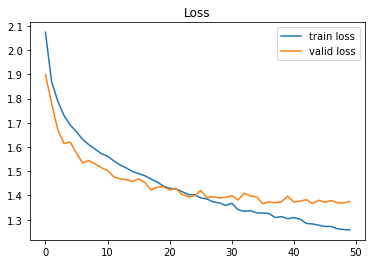

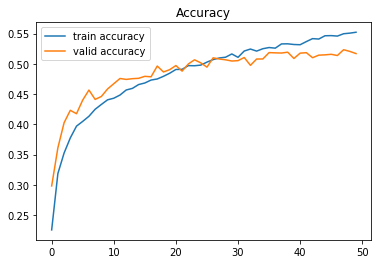

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()